## Data Overview

In [2]:
from pathlib import Path
import pandas as pd

CSV_PATH = Path("../labels.csv")

df = pd.read_csv(CSV_PATH)
print(df["film_type"].value_counts())

film_type
hp5           507
e100          240
portra160     239
5219          101
5207           72
800t           71
400tmax        70
portra800      70
portra400      65
delta400       61
velvia50       39
400tx          37
delta          36
delta100       35
phoenix200     33
delta3200      32
pan100         31
400            30
5222           29
100tmax        26
100            17
Name: count, dtype: int64


I plan to classify the photos bases on the famous film types and the one I uses most. So the final class is:
- Ilford hp5
- Kodak E100
- Kodak Portra Seires
- Other Colors
- Other B&Ws

So each class has above 200 samples.

In [3]:
from sklearn.model_selection import train_test_split

LABEL = Path("../labels_film.csv")

def film_label(film_type):
    t = film_type.strip().lower()

    ## Ilford hp5
    if t == "hp5":
        return "hp5"
    
    ## Kodak E100
    elif t == "e100":
        return "e100"
    
    ## Kodak Portra Series
    elif t in ["portra160", "portra400", "portra800"]:
        return "portra"
    
    ## Other B&W films
    elif t in ["400tmax","delta400","400tx","delta","delta100","delta3200","pan100","5222","100tmax"]:
        return "other_bw"
    
    ## Other Color films
    else:
        return "other_color"

df["film_label"] = df["film_type"].apply(film_label)

print("\nCounting film_label:")
print(df["film_label"].value_counts())

df.to_csv(LABEL, index=False)
print(f"\nSaved to: {LABEL.resolve()}")


Counting film_label:
film_label
hp5            507
portra         374
other_color    363
other_bw       357
e100           240
Name: count, dtype: int64

Saved to: /home/longwei/CS441/final/labels_film.csv


Splitted into train/test/val

In [4]:
df_train, df_temp = train_test_split(
    df,
    test_size=0.30,  
    stratify=df["film_label"],
)

df_val, df_test = train_test_split(
    df_temp,
    test_size=0.50, 
    stratify=df_temp["film_label"],
    random_state=42
)

df_train = df_train.copy()
df_val   = df_val.copy()
df_test  = df_test.copy()

df_train["split"] = "train"
df_val["split"]   = "val"
df_test["split"]  = "test"

df_all = pd.concat([df_train, df_val, df_test], axis=0, ignore_index=True)

df_all.to_csv(LABEL, index=False)

print("Saved to:", LABEL.resolve())
print(df_all["split"].value_counts())

Saved to: /home/longwei/CS441/final/labels_film.csv
split
train    1288
test      277
val       276
Name: count, dtype: int64


## Baseline

Resize the photo to a small size.  
Use global mean and std of RGB/HSV do a logistic regression.


### Data Processing
Train:Val:Test = 70:15:15

In [31]:
from pathlib import Path
from typing import Tuple

import numpy as np
import pandas as pd
from PIL import Image
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

# ===================== Configuration ======================

CSV = Path("../labels.csv")
RAW = Path("../raw_photos")

# ===================== Data processing ======================

def load_image_rgb(path: Path,
                   size: Tuple[int, int] = (256, 256)) -> np.ndarray:
    """Load an image and convert to RGB format."""
    img = Image.open(path).convert("RGB")
    img = img.resize(size)
    arr = np.asarray(img, dtype=np.float32) / 255.0
    return arr

def rgb_to_hsv(image: np.ndarray) -> np.ndarray:
    """Convert an RGB image to HSV format."""
    img = Image.fromarray((image * 255).astype(np.uint8), mode="RGB")
    hsv_img = img.convert("HSV")
    hsv_array = np.asarray(hsv_img, dtype=np.float32) / 255.0
    return hsv_array

def extract_features_rgb_hsv(path: Path) -> np.ndarray:
    """Extract RGB + HSV features from an image."""
    rgb = load_image_rgb(path)            # (H, W, 3)
    hsv = rgb_to_hsv(rgb)             # (H, W, 3)

    r = rgb[..., 0].ravel()
    g = rgb[..., 1].ravel()
    b = rgb[..., 2].ravel()

    h = hsv[..., 0].ravel()
    s = hsv[..., 1].ravel()
    v = hsv[..., 2].ravel()

    feats = [
        r.mean(), g.mean(), b.mean(),
        h.mean(), s.mean(), v.mean(),
        r.std(), g.std(), b.std(),
        h.std(), s.std(), v.std(),
    ]
    return np.array(feats, dtype=np.float32)

def build_dataset(df: pd.DataFrame,
                  img_root: Path) -> tuple[np.ndarray, np.ndarray]:
    """Build dataset from dataframe and image root."""
    xs = []
    ys = []

    for _, row in df.iterrows():
        fname = row["filename"]
        label = row["film_label"]

        img_path = img_root / fname
        if not img_path.is_file():
            print(f"[WARN] Image not found, skip: {img_path}")
            continue

        vec = extract_features_rgb_hsv(img_path)
        xs.append(vec)
        ys.append(label)

    X = np.stack(xs, axis=0)
    y = np.array(ys)
    return X, y


df = pd.read_csv(LABEL)
df_train = df[df["split"] == "train"].reset_index(drop=True)
df_val   = df[df["split"] == "val"].reset_index(drop=True)
df_test  = df[df["split"] == "test"].reset_index(drop=True)

print("Building train set features...")
X_train_lr, y_train_lr = build_dataset(df_train, RAW)

print("Building val set features...")
X_val_lr, y_val_lr = build_dataset(df_val, RAW)

print("Building test set features...")
X_test_lr, y_test_lr = build_dataset(df_test, RAW)

print(f"Feature dim: {X_train_lr.shape[1]}")

Building train set features...
Building val set features...
Building test set features...
Feature dim: 12


### Logistic Regression



Training Logistic Regression with C=0.001...
Validation Macro F1: 0.4525
Validation Accuracy: 0.5616

Training Logistic Regression with C=0.01...
Validation Macro F1: 0.5263
Validation Accuracy: 0.5978

Training Logistic Regression with C=0.1...
Validation Macro F1: 0.6210
Validation Accuracy: 0.6594

Training Logistic Regression with C=1.0...
Validation Macro F1: 0.6219
Validation Accuracy: 0.6594

Training Logistic Regression with C=10.0...
Validation Macro F1: 0.6152
Validation Accuracy: 0.6558

Training Logistic Regression with C=100.0...
Validation Macro F1: 0.6198
Validation Accuracy: 0.6594

Training Logistic Regression with C=1000.0...
Validation Macro F1: 0.6198
Validation Accuracy: 0.6594

Training Logistic Regression with C=10000.0...
Validation Macro F1: 0.6128
Validation Accuracy: 0.6522

Training Logistic Regression with C=100000.0...
Validation Macro F1: 0.6161
Validation Accuracy: 0.6558


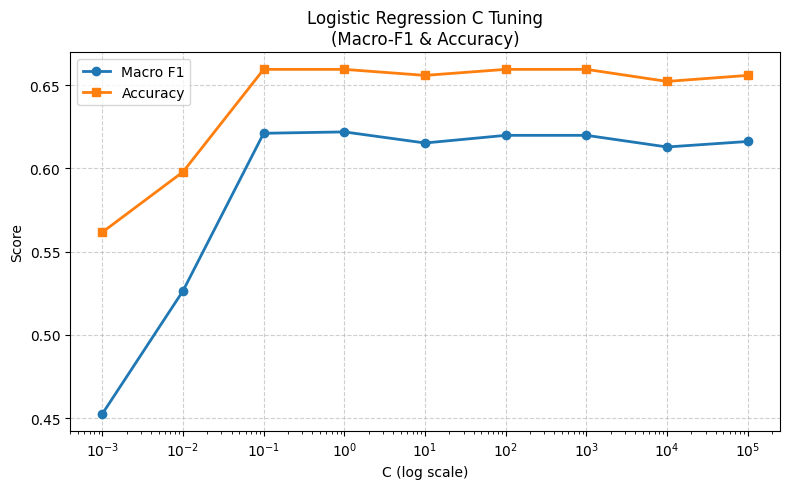


=== Test set performance ===
              precision    recall  f1-score   support

        e100       0.50      0.31      0.38        36
         hp5       0.68      0.71      0.70        76
    other_bw       0.57      0.55      0.56        53
 other_color       0.67      0.58      0.62        55
      portra       0.56      0.75      0.64        57

    accuracy                           0.61       277
   macro avg       0.60      0.58      0.58       277
weighted avg       0.61      0.61      0.60       277

Confusion matrix (test):
[[11  1  0  6 18]
 [ 0 54 21  1  0]
 [ 0 23 29  1  0]
 [ 6  0  1 32 16]
 [ 5  1  0  8 43]]
Accuracy (test): 0.6101083032490975
Macro F1 (test): 0.5793854228290742


In [41]:
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score
)
import matplotlib.pyplot as plt

scaler = StandardScaler(with_mean=True, with_std=True)
X_train_scaled_lr = scaler.fit_transform(X_train_lr)
X_val_scaled_lr   = scaler.transform(X_val_lr)
X_test_scaled_lr  = scaler.transform(X_test_lr)

Cs = [0.001,0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0,100000.0]
macro_f1_list = []
acc_list = []

for c in Cs:
    print(f"\nTraining Logistic Regression with C={c}...")
    
    clf = LogisticRegression(
        solver="lbfgs",
        max_iter=1000,
        n_jobs=-1,
        C=c,
    )
    
    clf.fit(X_train_scaled_lr, y_train_lr)
    y_val_pred = clf.predict(X_val_scaled_lr)
    macro_f1 = f1_score(y_val_lr, y_val_pred, average="macro")
    macro_f1_list.append(macro_f1)
    print(f"Validation Macro F1: {macro_f1:.4f}")

    acc = clf.score(X_val_scaled_lr, y_val_lr)
    acc_list.append(acc)
    print(f"Validation Accuracy: {acc:.4f}")

# ----------- Plot ------------
plt.figure(figsize=(8, 5))

plt.plot(Cs, macro_f1_list, marker='o', label="Macro F1", linewidth=2)
plt.plot(Cs, acc_list, marker='s', label="Accuracy", linewidth=2)

plt.xscale("log") 

plt.xlabel("C (log scale)")
plt.ylabel("Score")
plt.title("Logistic Regression C Tuning\n(Macro-F1 & Accuracy)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()

plt.tight_layout()
plt.show()

best_clf = LogisticRegression(
    solver="lbfgs",
    max_iter=1000,
    n_jobs=-1,
    C=Cs[np.argmax(macro_f1_list)],
)
best_clf.fit(X_train_scaled_lr, y_train_lr)

print("\n=== Test set performance ===")
y_test_pred = best_clf.predict(X_test_scaled_lr)
print(classification_report(y_test_lr, y_test_pred))
print("Confusion matrix (test):")
print(confusion_matrix(y_test_lr, y_test_pred))
from sklearn.metrics import accuracy_score
acc_test = accuracy_score(y_test_lr, y_test_pred)
print("Accuracy (test):", acc_test)
macro_f1_test = f1_score(y_test_lr, y_test_pred, average="macro")
print("Macro F1 (test):", macro_f1_test)

## CLIP

Use Pre-trained CLIP-Vit-B-32 to embed a photo  
Use logistic regression to classify the photo  

### CLIP

In [33]:
from pathlib import Path
from typing import Tuple
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
import numpy as np
import open_clip

# ===================== Configuration ======================
RAW = Path("../raw_photos")
LABEL = Path("../labels_film.csv")
OUT_DIR = Path("../clip_features")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# ===================== Dataset ======================
class FilmDataset(Dataset):
    def __init__(self,
                 df: pd.DataFrame,
                 img_root: Path,
                 preprocess) -> None:
        self.df = df
        self.img_root = img_root
        self.preprocess = preprocess

    def __len__(self) -> int:
        return len(self.df)

    def __getitem__(self, index: int) -> Tuple[torch.Tensor, str]:
        row = self.df.iloc[index]
        fname = row["filename"]
        label = row["film_label"]
        img_path = self.img_root / fname
        img = Image.open(img_path).convert("RGB")
        img_tensor = self.preprocess(img)

        return img_tensor, label


def extract_clip_features(split: str,
                          model: torch.nn.Module,
                          preprocess,
                          device: torch.device,
                          batch_size: int = 32) -> Tuple[np.ndarray, np.ndarray]:
    """Extract CLIP features from dataloader using the given model."""
    df_split = df[df["split"] == split].reset_index(drop=True)

    dataset = FilmDataset(df_split, RAW, preprocess)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    all_feats = []
    all_labels = []

    model.eval()
    with torch.no_grad():
        for batch_imgs, batch_labels in loader:
            batch_imgs = batch_imgs.to(device)
            image_features = model.encode_image(batch_imgs) 
            image_features = image_features / image_features.norm(dim=-1, keepdim=True)

            feats_np = image_features.cpu().numpy()
            all_feats.append(feats_np)
            all_labels.extend(batch_labels)

    X = np.concatenate(all_feats, axis=0)  
    y = np.array(all_labels)    
    print(f"Features shape: {X.shape}, labels shape: {y.shape}")
    return X, y
    
# ===================== Model ======================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model, _, preprocess = open_clip.create_model_and_transforms(
        "ViT-B-32",
        pretrained="laion2b_s34b_b79k"
    )
model.to(device)
model.eval()

features = {}
df = pd.read_csv(LABEL)
for split in ["test", "val", "train"]:
    print(f"\nExtracting features for split: {split}...")
    X, y = extract_clip_features(split, model, preprocess, device)
    features[split] = (X, y)
    np.savez(OUT_DIR / f"clip_{split}.npz", X=X, y=y)

print("\n✅ All splits extracted and saved to:", OUT_DIR)

Using device: cuda

Extracting features for split: test...
Features shape: (277, 512), labels shape: (277,)

Extracting features for split: val...
Features shape: (276, 512), labels shape: (276,)

Extracting features for split: train...
Features shape: (1288, 512), labels shape: (1288,)

✅ All splits extracted and saved to: ../clip_features


### Linear Probe

C=0.001: val_acc=0.7862, macro_F1=0.7665
C= 0.01: val_acc=0.8116, macro_F1=0.8036
C=  0.1: val_acc=0.7899, macro_F1=0.7839
C=  1.0: val_acc=0.7790, macro_F1=0.7728
C= 10.0: val_acc=0.7826, macro_F1=0.7760
C=100.0: val_acc=0.7826, macro_F1=0.7773
C=1000.0: val_acc=0.7826, macro_F1=0.7773
C=10000.0: val_acc=0.7862, macro_F1=0.7821
C=100000.0: val_acc=0.7862, macro_F1=0.7821

Best C on val (by Macro-F1): 0.01, Macro-F1=0.8036
[0.45247160262417996, 0.5263396089671325, 0.6210329220532919, 0.6218521528099692, 0.6151914646115315, 0.6197876705590821, 0.6197931852039746, 0.6127988923503965, 0.616102610545658]
[0.7665441351945284, 0.8036129453679892, 0.7839113167012174, 0.7727955592900976, 0.7760071426443107, 0.7772875734133473, 0.7772875734133473, 0.7821291065981217, 0.7821291065981217]


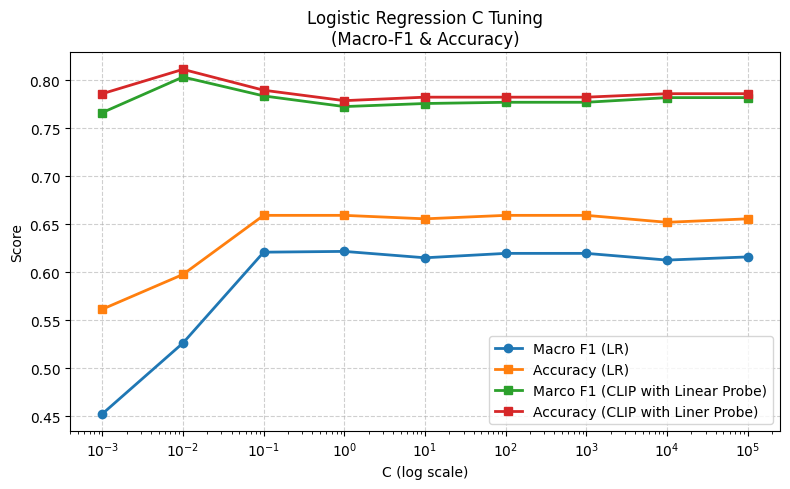


=== Test set performance (CLIP + LR) ===
              precision    recall  f1-score   support

        e100       0.87      0.72      0.79        36
         hp5       0.77      0.80      0.79        76
    other_bw       0.70      0.66      0.68        53
 other_color       0.74      0.71      0.72        55
      portra       0.74      0.84      0.79        57

    accuracy                           0.75       277
   macro avg       0.76      0.75      0.75       277
weighted avg       0.76      0.75      0.75       277

Confusion matrix (test):
[[26  0  0  6  4]
 [ 0 61 15  0  0]
 [ 0 18 35  0  0]
 [ 3  0  0 39 13]
 [ 1  0  0  8 48]]
Macro F1 (test): 0.7527389361363269
Accuracy (test): 0.7545126353790613


In [42]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
from matplotlib import pyplot as plt

FEATURE = Path("../clip_features")

def load_split(name: str):
    data = np.load(FEATURE/ f"clip_{name}.npz", allow_pickle=True)
    X = data["X"]
    y = data["y"]
    return X, y

X_train, y_train = load_split("train")
X_val, y_val = load_split("val")
X_test, y_test = load_split("test")

scaler = StandardScaler(with_mean=True, with_std=True)
X_train_sc = scaler.fit_transform(X_train)
X_val_sc   = scaler.transform(X_val)
X_test_sc  = scaler.transform(X_test)


#Cs = [0.001, 0.01, 0.1, 1, 10, 100,1000,10000,100000]
best_C = None
best_macro_f1 = -1
clip_acc_list = []
clip_f1_list = []

for C in Cs:
    clf = LogisticRegression(
        C=C,
        max_iter=2000,
        solver="lbfgs",
        n_jobs=-1,
    )
    clf.fit(X_train_sc, y_train)
    y_val_pred = clf.predict(X_val_sc)

    macro_f1 = f1_score(y_val, y_val_pred, average="macro")
    acc = clf.score(X_val_sc, y_val)
    print(f"C={C:>5}: val_acc={acc:.4f}, macro_F1={macro_f1:.4f}")
    clip_acc_list.append(acc)
    clip_f1_list.append(macro_f1)

    if macro_f1 > best_macro_f1:
        best_macro_f1 = macro_f1
        best_C = C

print(f"\nBest C on val (by Macro-F1): {best_C}, Macro-F1={best_macro_f1:.4f}")

# ----------- Plot ------------
print(macro_f1_list)
print(clip_f1_list)
plt.figure(figsize=(8, 5))
plt.plot(Cs, macro_f1_list, marker='o', label="Macro F1 (LR)", linewidth=2)
plt.plot(Cs, acc_list, marker='s', label="Accuracy (LR)", linewidth=2)
plt.plot(Cs, clip_f1_list, marker='s', label="Marco F1 (CLIP with Linear Probe)", linewidth=2)
plt.plot(Cs, clip_acc_list, marker='s', label="Accuracy (CLIP with Liner Probe)", linewidth=2)

plt.xscale("log") 

plt.xlabel("C (log scale)")
plt.ylabel("Score")
plt.title("Logistic Regression C Tuning\n(Macro-F1 & Accuracy)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()

plt.tight_layout()
plt.show()

X_trainval = np.concatenate([X_train_sc, X_val_sc], axis=0)
y_trainval = np.concatenate([y_train, y_val], axis=0)

final_clf = LogisticRegression(
        C=best_C,
        max_iter=2000,
        solver="lbfgs",
        n_jobs=-1,
    )
final_clf.fit(X_trainval, y_trainval)

y_test_pred = final_clf.predict(X_test_sc)

print("\n=== Test set performance (CLIP + LR) ===")
print(classification_report(y_test, y_test_pred))
print("Confusion matrix (test):")
print(confusion_matrix(y_test, y_test_pred))

macro_f1_test = f1_score(y_test, y_test_pred, average="macro")
print("Macro F1 (test):", macro_f1_test)
acc_test = accuracy_score(y_test, y_test_pred)
print("Accuracy (test):", acc_test)

### MLP Probe

Device: cuda
lr=1e-04  best_val_macroF1=0.8637  val_acc=0.8659
lr=3e-04  best_val_macroF1=0.8522  val_acc=0.8442
lr=1e-03  best_val_macroF1=0.8529  val_acc=0.8478
lr=3e-03  best_val_macroF1=0.8655  val_acc=0.8696
lr=1e-02  best_val_macroF1=0.8535  val_acc=0.8478
lr=3e-02  best_val_macroF1=0.8525  val_acc=0.8297
lr=1e-01  best_val_macroF1=0.8581  val_acc=0.8297
lr=1e+00  best_val_macroF1=0.8474  val_acc=0.8514
lr=1e+01  best_val_macroF1=0.8589  val_acc=0.8333
lr=1e+02  best_val_macroF1=0.8278  val_acc=0.7391


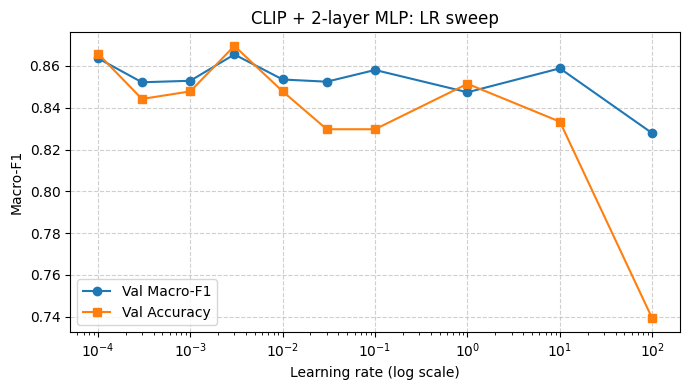

In [35]:
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score



class NpDataset(Dataset):
    def __init__(self, X: np.ndarray, y: np.ndarray):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


class MLPProbe(nn.Module):
    def __init__(self, in_dim=512, hidden_dim=256, num_classes=5, dropout=0.2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, num_classes),
        )

    def forward(self, x):
        return self.net(x)


@torch.no_grad()
def eval_model(model, loader, device):
    model.eval()
    ys, preds = [], []
    for Xb, yb in loader:
        Xb = Xb.to(device)
        logits = model(Xb)
        pb = torch.argmax(logits, dim=1).cpu().numpy()
        preds.append(pb)
        ys.append(yb.numpy())
    y_true = np.concatenate(ys)
    y_pred = np.concatenate(preds)
    return y_true, y_pred

def train_one_lr(lr: float, epochs: int = 35, hidden_dim: int = 256, dropout: float = 0.2):
    model = MLPProbe(X_train_sc.shape[1], hidden_dim, len(le.classes_), dropout).to(device)
    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    crit = nn.CrossEntropyLoss()

    best_val = -1.0
    best_state = None

    for ep in range(1, epochs + 1):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad()
            loss = crit(model(xb), yb)
            loss.backward()
            opt.step()

        yv_true, yv_pred = eval_model(model, val_loader, device)
        val_macro = f1_score(yv_true, yv_pred, average="macro")
        acc = accuracy_score(yv_true, yv_pred)

        if val_macro > best_val:
            best_val = val_macro
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            acc = accuracy_score(yv_true, yv_pred)
    

    return best_val,acc

le = LabelEncoder()
le.fit(np.concatenate([y_train, y_val, y_test]))
y_train_i = le.transform(y_train)
y_val_i   = le.transform(y_val)
y_test_i  = le.transform(y_test)


scaler = StandardScaler(with_mean=True, with_std=True)
X_train_sc = scaler.fit_transform(X_train)
X_val_sc   = scaler.transform(X_val)
X_test_sc  = scaler.transform(X_test)


batch_size = 64
train_loader = DataLoader(NpDataset(X_train_sc, y_train_i), batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(NpDataset(X_val_sc, y_val_i), batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(NpDataset(X_test_sc, y_test_i), batch_size=batch_size, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

lrs = [1e-4, 3e-4, 1e-3, 3e-3, 1e-2, 3e-2,1e-1,1,10,100]
f1_list = []
acc_list = []
best_lr = None
best_f1 = -1

for lr in lrs:
    best_val, acc = train_one_lr(lr=lr, epochs=50)
    f1_list.append(best_val)
    acc_list.append(acc)
    print(f"lr={lr:.0e}  best_val_macroF1={best_val:.4f}  val_acc={acc:.4f}")
    if best_val > best_f1:
        best_f1 = best_val
        best_lr = lr


plt.figure(figsize=(7,4))
plt.plot(lrs, f1_list, marker="o", label="Val Macro-F1")
plt.plot(lrs, acc_list, marker="s", label="Val Accuracy")
plt.xscale("log")
plt.xlabel("Learning rate (log scale)")
plt.ylabel("Macro-F1")
plt.title("CLIP + 2-layer MLP: LR sweep")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

In [36]:
print("\nBest lr =", best_lr, "best val macroF1 =", best_f1)

final_model = MLPProbe(
    in_dim=X_train_sc.shape[1],
    hidden_dim=256,
    num_classes=len(le.classes_),
    dropout=0.2
).to(device)

opt = torch.optim.AdamW(final_model.parameters(), lr=best_lr, weight_decay=1e-4)
crit = nn.CrossEntropyLoss()

final_model.train()
for ep in range(50):
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        opt.zero_grad()
        loss = crit(final_model(xb), yb)
        loss.backward()
        opt.step()

yt_true, yt_pred = eval_model(final_model, test_loader, device)

print("\n=== Test set performance (CLIP + MLP, best lr) ===")
print(classification_report(yt_true, yt_pred, target_names=list(le.classes_)))
print("Confusion matrix (test):")
print(confusion_matrix(yt_true, yt_pred))
print("Macro F1 (test):", f1_score(yt_true, yt_pred, average="macro"))
print("Accuracy (test):", accuracy_score(yt_true, yt_pred))


Best lr = 0.003 best val macroF1 = 0.8654982008588782

=== Test set performance (CLIP + MLP, best lr) ===
              precision    recall  f1-score   support

        e100       0.83      0.81      0.82        36
         hp5       0.80      0.78      0.79        76
    other_bw       0.70      0.74      0.72        53
 other_color       0.84      0.78      0.81        55
      portra       0.82      0.88      0.85        57

    accuracy                           0.79       277
   macro avg       0.80      0.80      0.80       277
weighted avg       0.80      0.79      0.79       277

Confusion matrix (test):
[[29  1  0  4  2]
 [ 0 59 17  0  0]
 [ 0 14 39  0  0]
 [ 3  0  0 43  9]
 [ 3  0  0  4 50]]
Macro F1 (test): 0.795588557445645
Accuracy (test): 0.7942238267148014


### Misclassified Photos

In [37]:
import pandas as pd
import numpy as np
from pathlib import Path
import shutil

df = pd.read_csv("../labels_film.csv")
df_test = df[df["split"] == "test"].reset_index(drop=True)

mis_idx = np.where(yt_true != yt_pred)[0]
print(f"Misclassified: {len(mis_idx)} / {len(yt_true)}")

df_mis = df_test.loc[mis_idx, ["filename"]].copy()
df_mis["y_true"] = le.inverse_transform(yt_true[mis_idx])
df_mis["y_pred"] = le.inverse_transform(yt_pred[mis_idx])

df_mis.to_csv("../misclassified_images.csv", index=False)
print("Saved misclassified_images.csv")


IMG_ROOT = Path("../raw_photos")

OUT_DIR = Path("../misclassified_images")
OUT_DIR.mkdir(parents=True, exist_ok=True)

for fname in df_mis["filename"]:
    src = IMG_ROOT / fname
    if not src.is_file():
        print(f"[WARN] missing file: {src}")
        continue
    shutil.copy2(src, OUT_DIR / fname)

print(f"Copied {len(df_mis)} misclassified images to {OUT_DIR}")

Misclassified: 57 / 277
Saved misclassified_images.csv
Copied 57 misclassified images to ../misclassified_images
